### Multi-input CNN - Stefano Maxenti - Riccardo Mencucci - "team_durian"

In [ ]:
# The following lines are needed in Gradient Paperspace because these libraries are not installed by default
!pip install scipy sklearn pandas seaborn pillow visualkeras attention

### Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
from keras import backend as K
print(tf.__version__)

2.6.0


Set seed for reproducibility

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Let's import the dataset

In [4]:
dataset = pd.read_csv('training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


Sponginess  Wonder level  Crunchiness  Loudness on impact  Meme creativity  \
0     7.97698       4.33494     10.67282             1.76692          3.22440   
1     8.07824       4.44616     10.56160             1.70716          3.32566   
2     8.02844       4.22372     10.56160             1.64906          3.17460   
3     8.02844       4.22372     10.56160             1.70716          3.17460   
4     7.87572       4.44616     10.45038             1.70716          3.27586   

   Soap slipperiness  Hype root  
0          51.681460    3.65434  
1          51.563598    3.47672  
2          50.863080    3.47672  
3          45.841581    3.47672  
4          47.126421    3.47672

Loading the dataset and taking a look at the data distribution

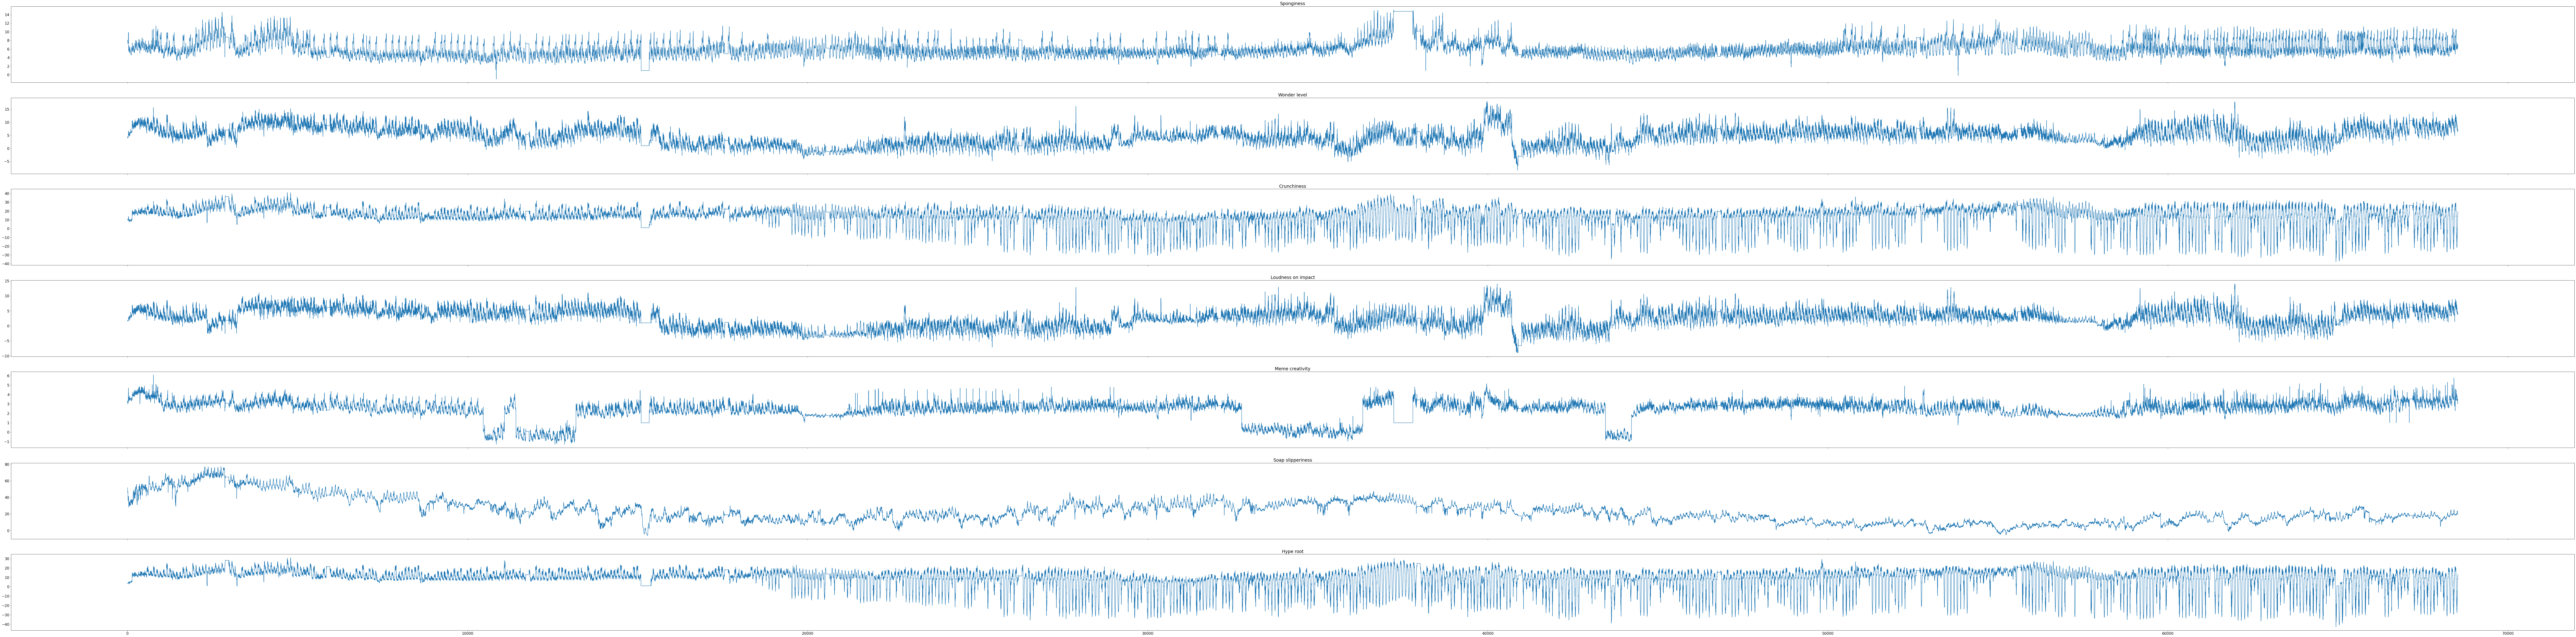

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(200,50))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

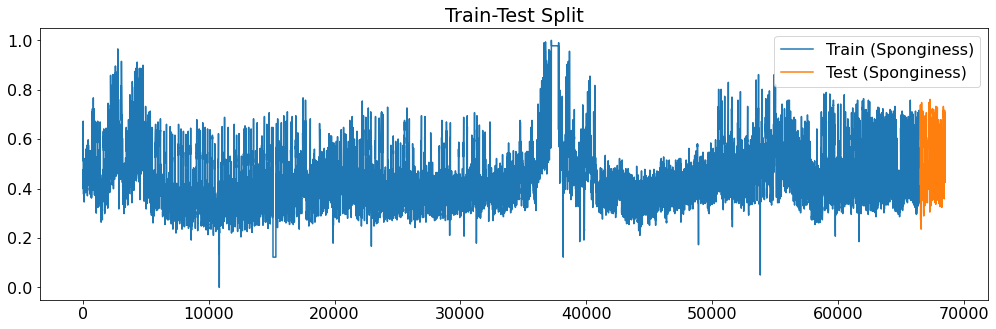

Sponginess  Wonder level  Crunchiness  Loudness on impact  Meme creativity  \
0    0.556576      0.481134     0.612986            0.468044         0.613765   
1    0.562874      0.485320     0.611573            0.465453         0.627575   
2    0.559777      0.476949     0.611573            0.462934         0.606973   
3    0.559777      0.476949     0.611573            0.465453         0.606973   
4    0.550279      0.485320     0.610160            0.465453         0.620783   

   Soap slipperiness  Hype root  
0           0.691885   0.629100  
1           0.690471   0.626693  
2           0.682070   0.626693  
3           0.621844   0.626693  
4           0.637254   0.626693

In [6]:
test_size = 2000 #we will use the test set as validation set
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

# Example of division
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()
X_train_raw.head()

In [7]:
# We use sliding windows of 300 elements with stride equal to 1
window = 300
stride = 1

future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 300, 7)

In [8]:
def build_sequences(df, target_labels=['pollution'], window=400, stride=10, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting

In [9]:
target_labels = dataset.columns
print(target_labels)
telescope = 1152 # 1152 is used because this model was trained before phase 2 was removed

Index(['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact',
       'Meme creativity', 'Soap slipperiness', 'Hype root'],
      dtype='object')


In [10]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((65148, 300, 7), (65148, 1152, 7), (648, 300, 7), (648, 1152, 7))

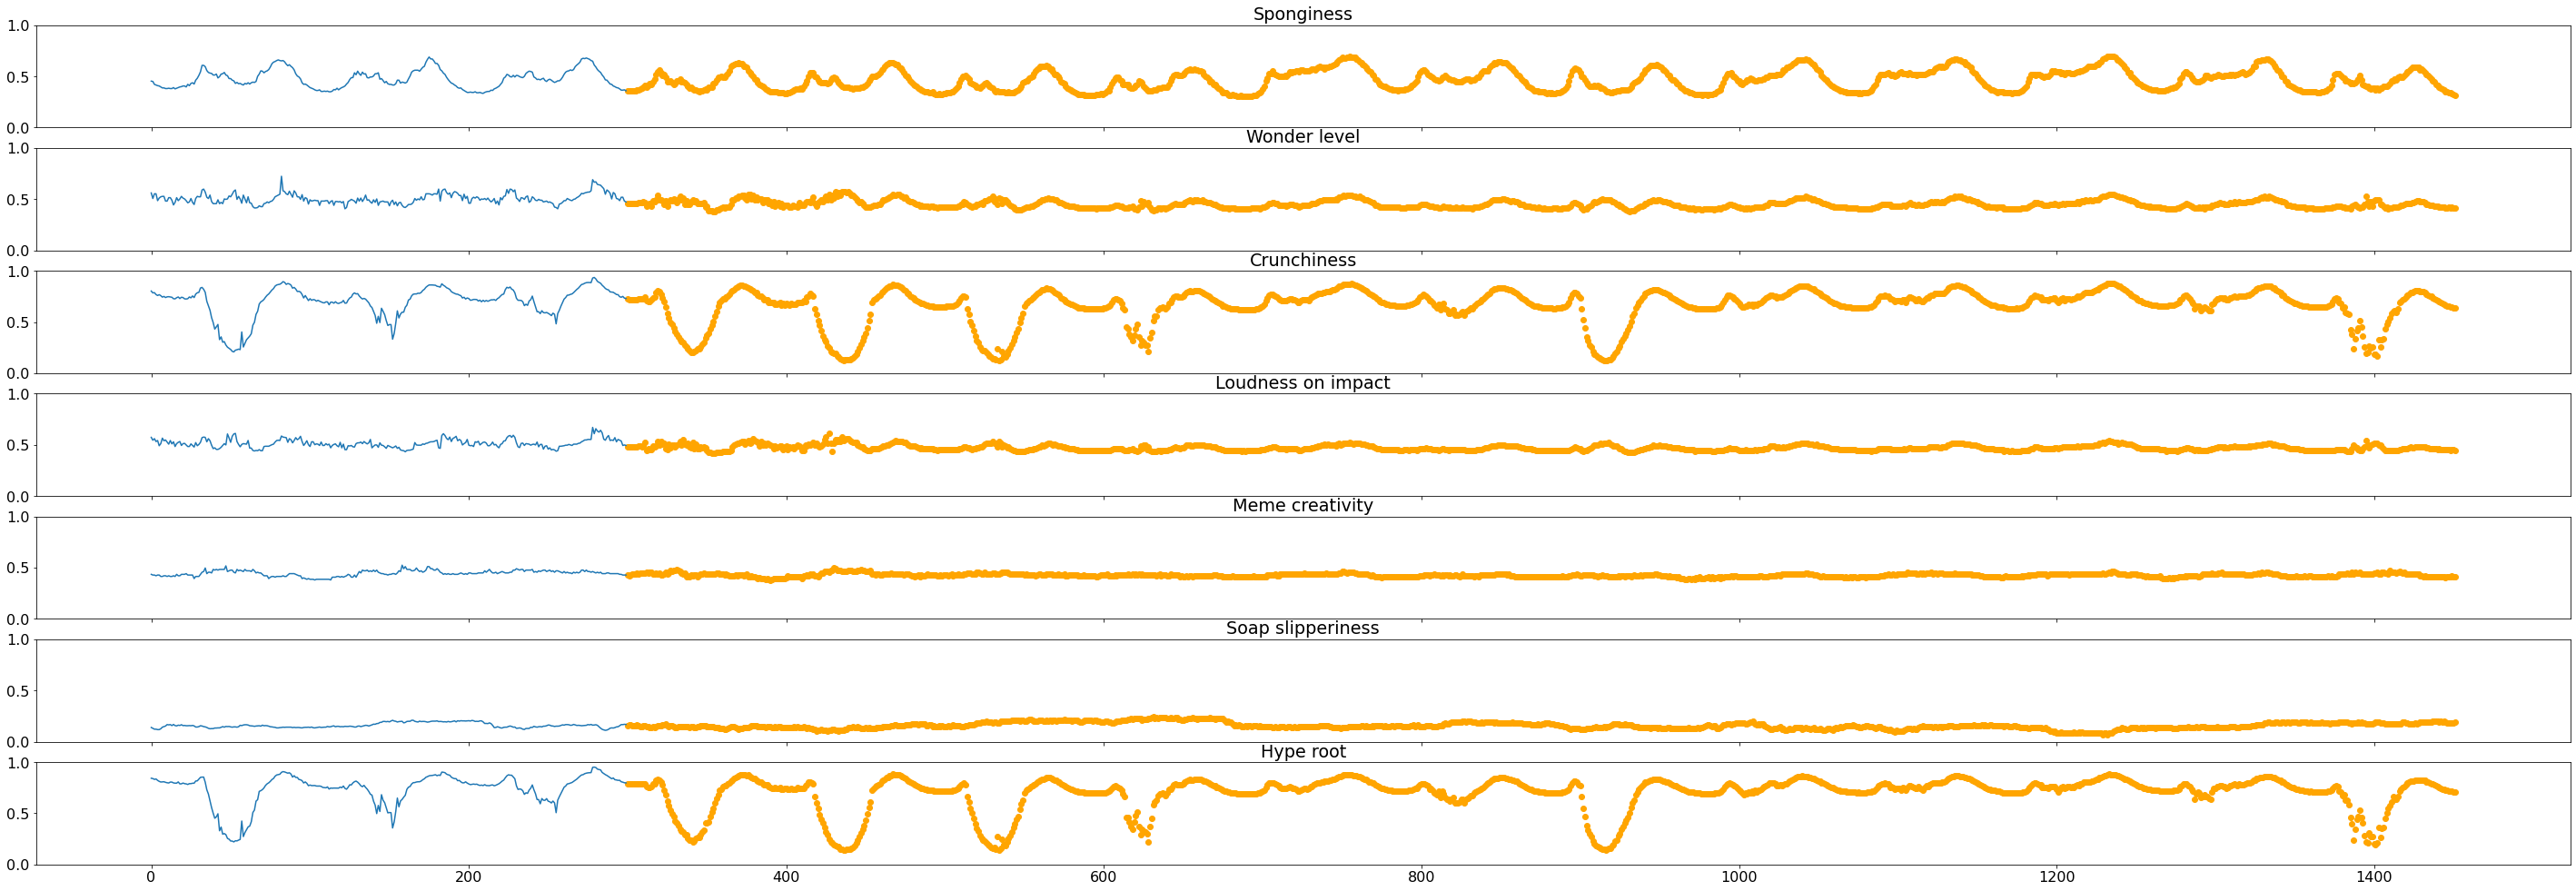

In [12]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(50,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [13]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 150

In [14]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('regression_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

#now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Multi-input-CNN'
exp_dir = os.path.join(exps_dir, model_name)# + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_best.ckpt'), 
                                                   save_weights_only=False, save_best_only=True)  # False to save the model directly
#callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
    callbacks.append(es_callback)
callbacks.append(tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.5, min_lr=1e-7))

In [15]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true))))#*(X_max-X_min)+X_min)))
def root_mean_squared_error_denorm(y_true, y_pred):
    return K.sqrt(K.mean(K.square(((y_pred*(X_max-X_min)+X_min)) - (y_true*(X_max-X_min)+X_min))))#*(X_max-X_min)+X_min)))
 
# Inspired by https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ and the author's book
def build_model(input_shape, output_shape):
    in_layers, out_layers = list(), list()
    for _ in range(7):
        inputs = Input(shape=(input_shape[0],1))
        conv1 = Conv1D(128, 100, activation='relu')(inputs)
        conv1 = MaxPooling1D()(conv1)
        conv2 = Conv1D(256, 50, activation='relu')(conv1)
        conv2 = MaxPooling1D()(conv2)
        conv2 = Conv1D(512, 10, activation='relu')(conv2)
        pool1 = MaxPooling1D()(conv2)
        flat = tfkl.GlobalAveragePooling1D()(pool1)
        flat = tfkl.Dense(250)(flat)
        flat = tfkl.Dropout(0.3)(flat)
        flat = tfkl.Dense(250)(flat)
        # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense2 = tfkl.Dense(output_shape[-1]*output_shape[-2])(merged)
    outputs = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-4), metrics=[root_mean_squared_error_denorm])
    model.summary()
    return model

In [16]:
model = build_model(input_shape, output_shape)

input_data = [X_train[:,:,i].reshape((X_train.shape[0],input_shape[0],1)) for i in range(7)]
test = [X_test[:,:,i].reshape((X_test.shape[0],input_shape[0],1)) for i in range(7)]
    

2022-01-20 13:23:33.870441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 13:23:33.882661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 13:23:33.883717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 13:23:33.886361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 13:23:33.887391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300, 1)]     0                                            
______________________________________________________________________________________________

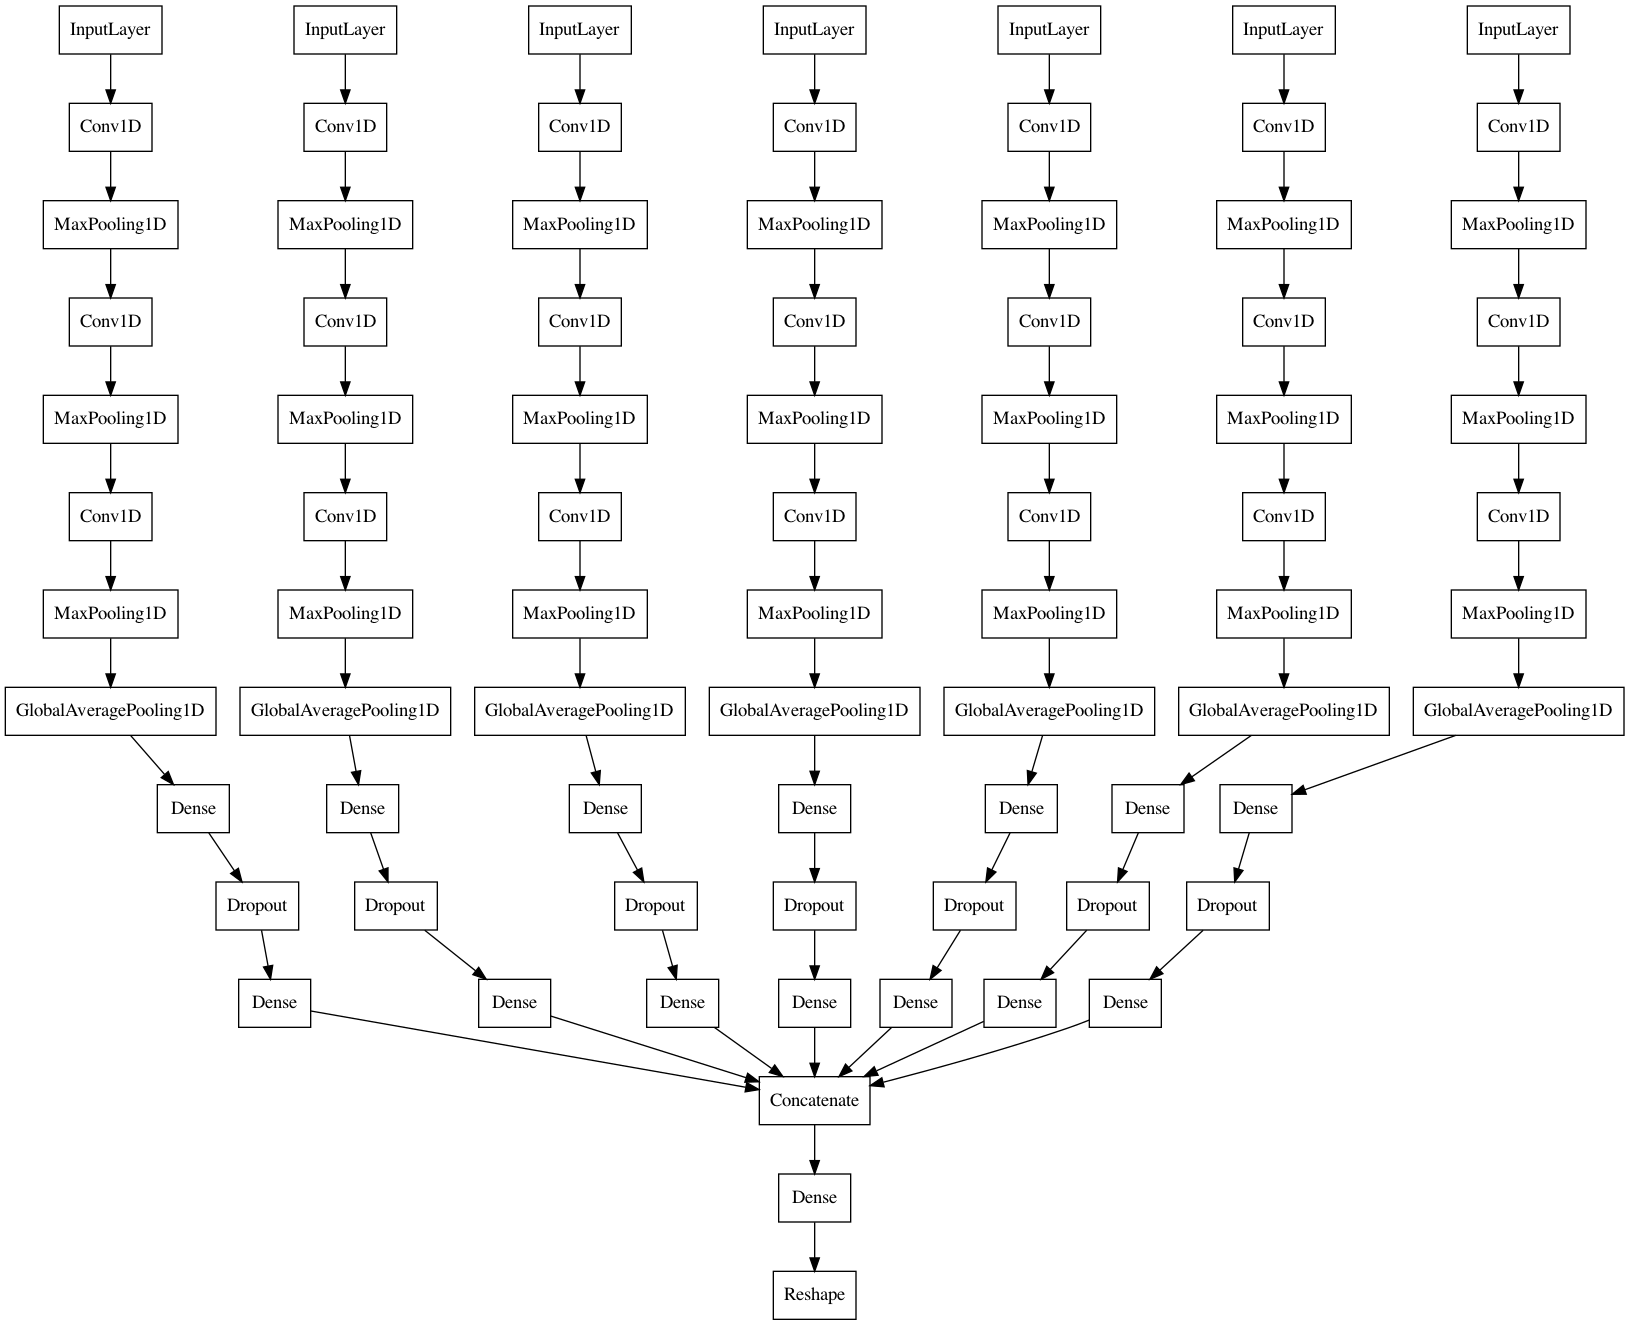

In [4]:
tfk.utils.plot_model(
    model,
    to_file='Multi-input-CNN.png',
    expand_nested=True,
    show_layer_names=False
)

In [17]:
model.fit(input_data, 
          y_train, 
          validation_data = (test, y_test), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=1, 
          callbacks=callbacks)

2022-01-06 21:01:35.218841: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2101413888 exceeds 10% of free system memory.
2022-01-06 21:01:38.158349: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2101413888 exceeds 10% of free system memory.
2022-01-06 21:01:40.200683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-01-06 21:01:43.421910: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


1018/1018 [==============================] - 60s 54ms/step - loss: 0.0178 - root_mean_squared_error_denorm: 7.0305 - val_loss: 0.0106 - val_root_mean_squared_error_denorm: 5.8754
Epoch 2/150
1018/1018 [==============================] - 54s 53ms/step - loss: 0.0104 - root_mean_squared_error_denorm: 5.3323 - val_loss: 0.0086 - val_root_mean_squared_error_denorm: 5.1344
Epoch 3/150
1018/1018 [==============================] - 54s 54ms/step - loss: 0.0091 - root_mean_squared_error_denorm: 4.9363 - val_loss: 0.0076 - val_root_mean_squared_error_denorm: 4.6915
Epoch 4/150
1018/1018 [==============================] - 54s 53ms/step - loss: 0.0083 - root_mean_squared_error_denorm: 4.7296 - val_loss: 0.0084 - val_root_mean_squared_error_denorm: 4.7394
Epoch 5/150
1018/1018 [==============================] - 54s 53ms/step - loss: 0.0075 - root_mean_squared_error_denorm: 4.5939 - val_loss: 0.0082 - val_root_mean_squared_error_denorm: 4.7744
Epoch 6/150
1018/1018 [==============================] - 

In [18]:
# Predict the test set 
predictions = model.predict(test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test[:,:864,:].flatten(),predictions[:,:864,:].flatten())
mean_absolute_error = tfk.metrics.mae(y_test[:,:864,:].flatten(),predictions[:,:864,:].flatten())
print(mean_squared_error, mean_absolute_error)
# As before, the model was trained with 1152 values as output
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
print(mean_squared_error, mean_absolute_error)

(648, 1152, 7)
tf.Tensor(0.0073836897, shape=(), dtype=float32) tf.Tensor(0.061441116, shape=(), dtype=float32)
tf.Tensor(0.0076059727, shape=(), dtype=float32) tf.Tensor(0.063056394, shape=(), dtype=float32)


In [20]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(50,30))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()


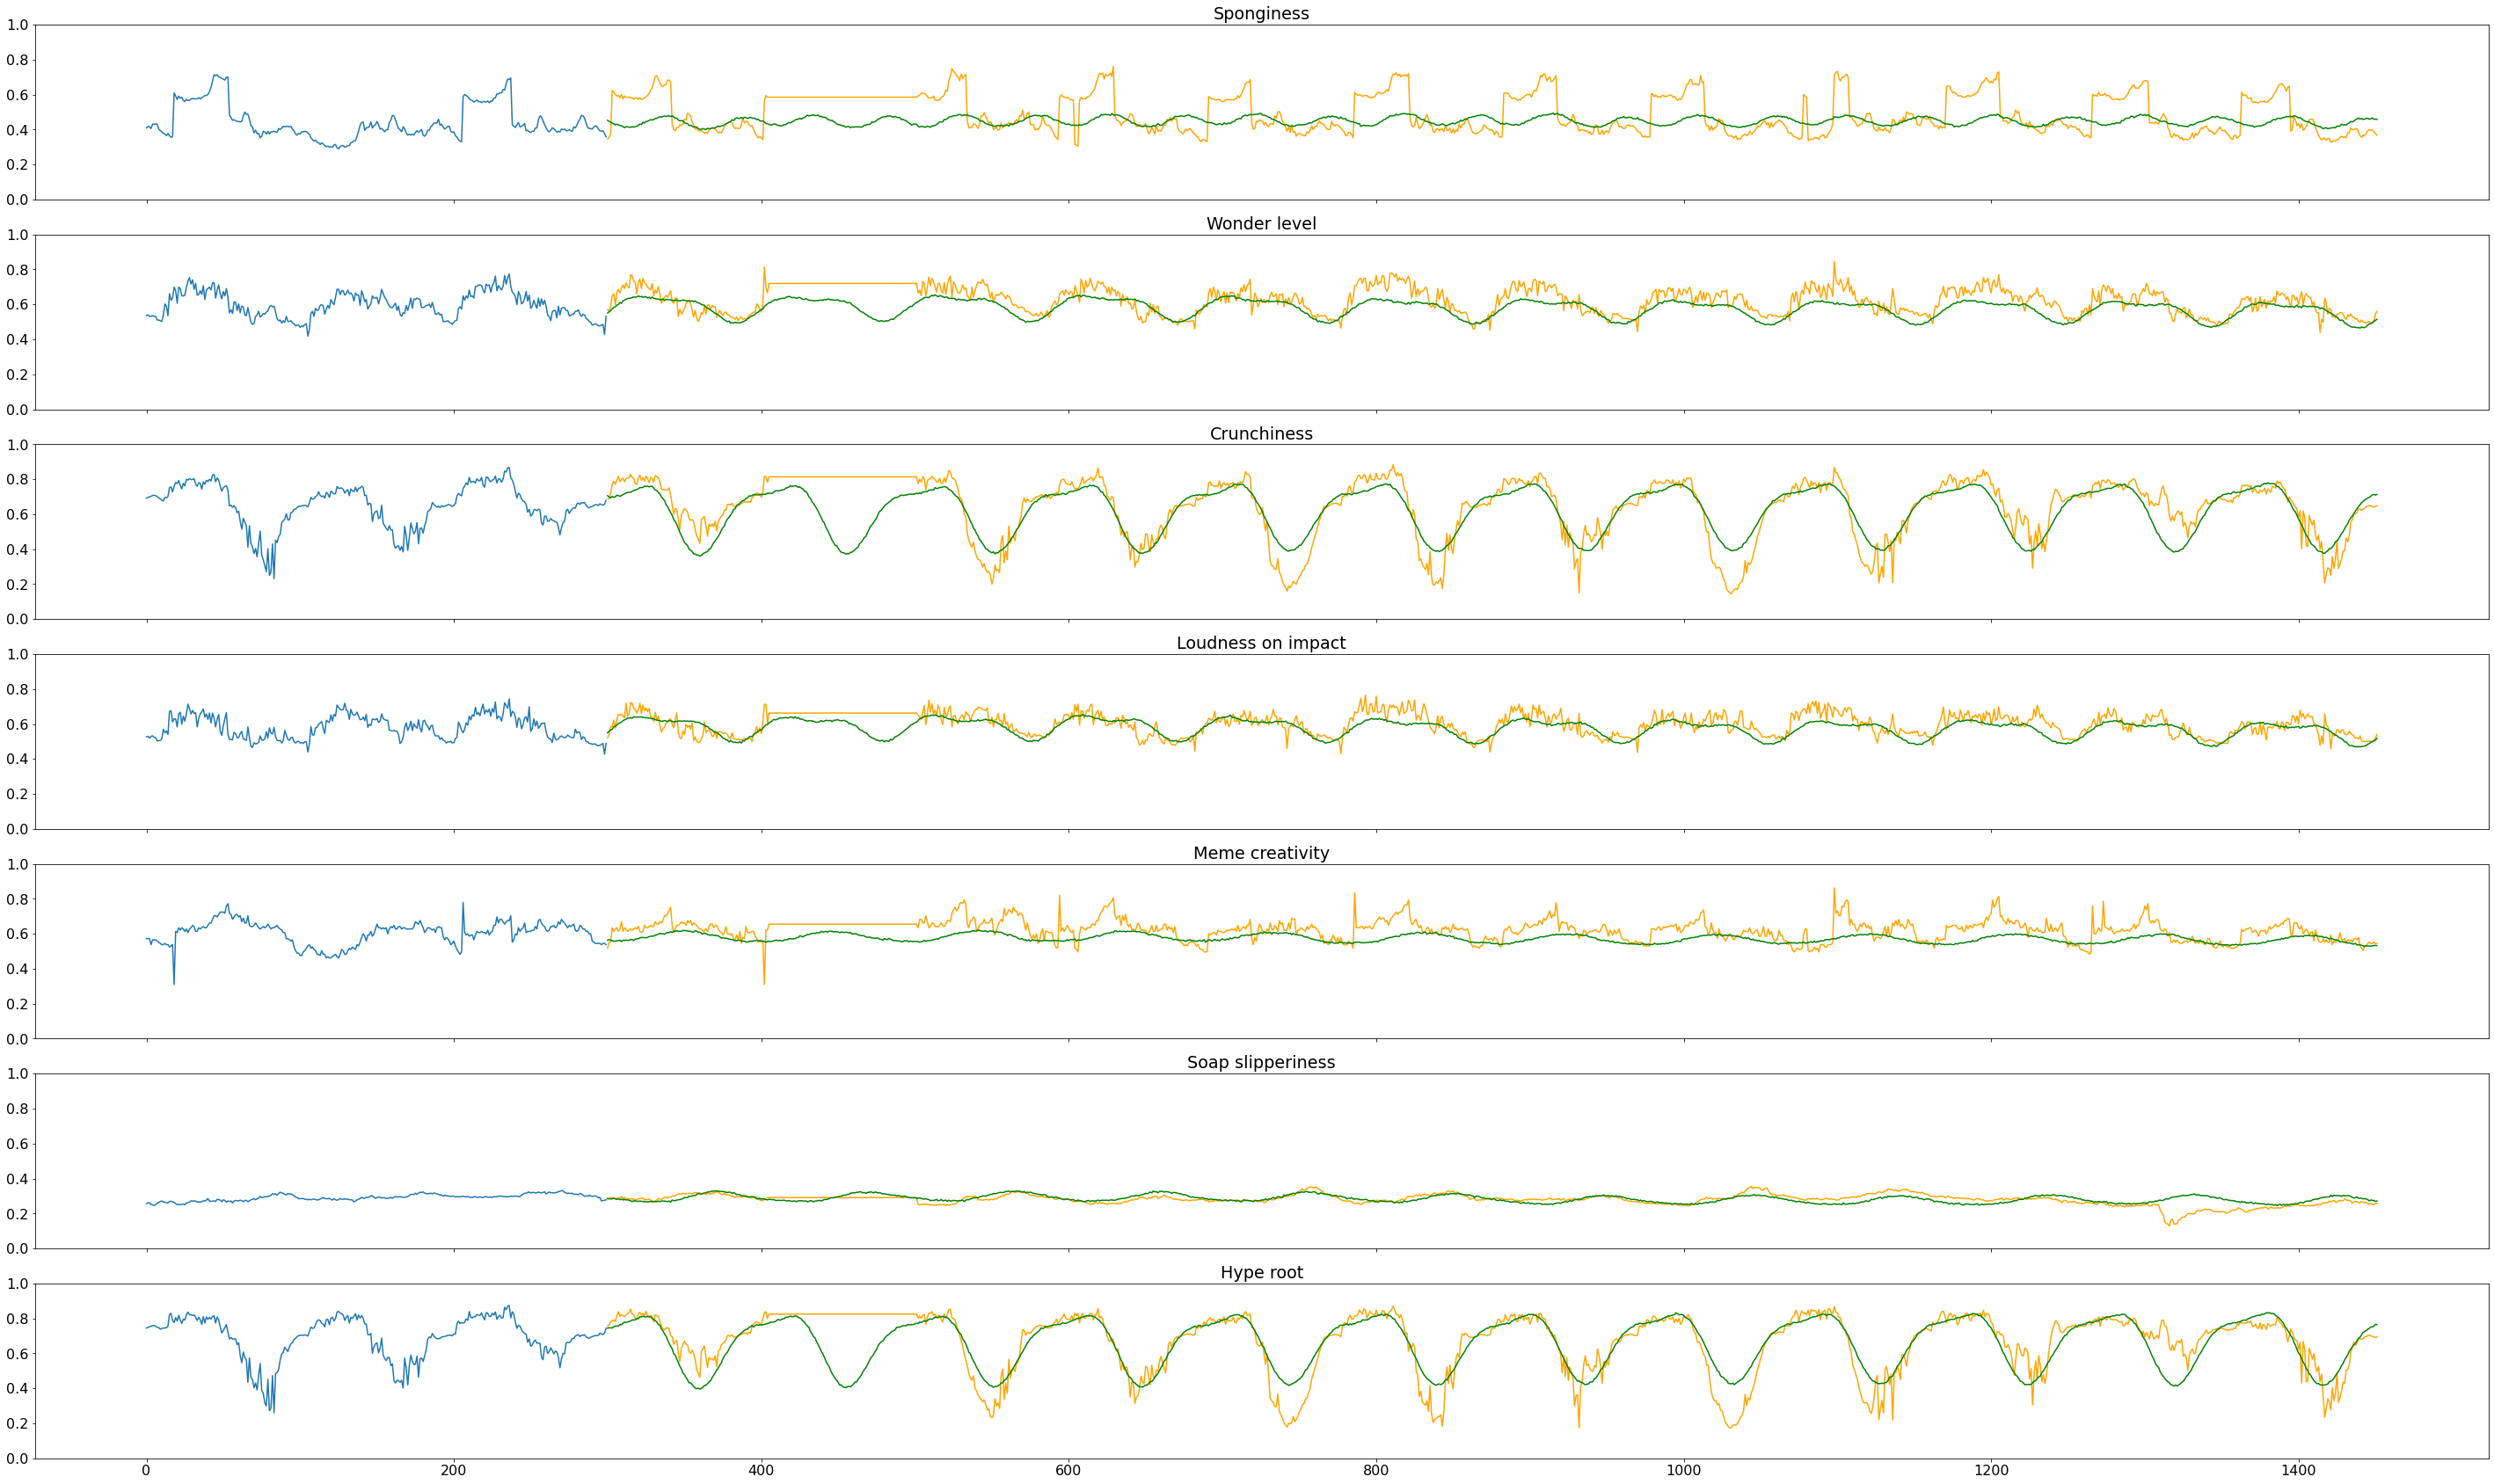

In [23]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)